In [19]:
import pandas as pd
import numpy as np

In [20]:
train_data   = pd.read_csv('./train_final.csv')
test_data    = pd.read_csv('./test_final.csv')
spray_data   = pd.read_csv('./assets/spray.csv')

In [21]:
test_data.head()

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude     ...      \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991     ...       
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991     ...       
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991     ...       
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991     ...       
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991     ...       

   WetBulb  CodeSum  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  \
0       64     None          0.0        29.28     29.99          8.9   
1       64     None          0.0        29.28     29.99          8.9   
2       64     None          0.0        29.28     29.99          8.9   
3       64     None          0.0        29.28     29.99          8.9   
4       64     None          0.0        29.28     29.99          8.9   

   ResultDir AvgSpeed  PrecipCat  NewCodeSum  
0         18     10.0  No_Precip           1  
1         18     10.0  No_Precip           1  
2         18     10.0  No_Precip           1  
3         18     10.0  No_Precip           1  
4         18     10.0  No_Precip           1  

[5 rows x 26 columns]

In [22]:
train_data.shape, test_data.shape

((10506, 27), (116293, 26))

In [23]:
def  date_separate (df):
    df = df.copy()
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    df['Day'] = pd.DatetimeIndex(df['Date']).day
    return df

In [24]:
train_data  = date_separate(train_data)
test_data  = date_separate(test_data)

In [25]:
test_data['Species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
UNSPECIFIED CULEX         14345
CULEX ERRATICUS           14345
Name: Species, dtype: int64

In [26]:
#adding to pipiens/restauns, so it can maybe learn from those, since those are the ones that carry wnv?
#so it makes it extra sensitive?

new_species = []
for i in test_data['Species']:
    if i == 'UNSPECIFIED CULEX':
        new_species.append('CULEX PIPIENS/RESTUANS')
    else:
        new_species.append(i)
test_data['Species'] = new_species        

In [27]:
test_data['Species'].value_counts()

CULEX PIPIENS/RESTUANS    29704
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
CULEX ERRATICUS           14345
Name: Species, dtype: int64

In [28]:
train_data['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [29]:
test_data.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'CodeSum',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'PrecipCat', 'NewCodeSum', 'Year', 'Month', 'Day'],
      dtype='object')

In [30]:
#turns out some addresses have missing zipcodes, maybe calculate based on lat/long?

import re
zipcodes = []
for i in train_data['Address']:
    reg = re.compile('\d{5}')
    zipcodes.append(reg.findall(i)) 
#train_data['Zipcode'] = zipcodes

zipcodes2 = []
for i in test_data['Address']:
    reg = re.compile('\d{5}')
    zipcodes2.append(reg.findall(i)) 
#test_data['Zipcode'] = zipcodes2

In [31]:
train_data.drop(columns=['AddressNumberAndStreet', 'Date',
                         'Latitude', 'Longitude','CodeSum',
                         'Street', 'Address'], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=['Trap','Species', 'NewCodeSum','PrecipCat'], drop_first=True)

test_data.drop(columns=['AddressNumberAndStreet','Date',
                        'Latitude', 'Longitude','CodeSum','Street','Address'], axis=1, inplace=True)

test_data = pd.get_dummies(test_data, columns=['Trap','Species','NewCodeSum','PrecipCat'], drop_first=True)

In [32]:
train_data.shape, test_data.shape

((10506, 163), (116293, 175))

In [33]:
#making sure index is in order
test_data = test_data.sort_values(by=['Id'])

In [34]:
y = train_data['WnvPresent']
X = train_data.drop(['WnvPresent'], axis=1)

In [35]:
[col for col in X.columns if col not in test_data.columns]

['NumMosquitos']

In [36]:
#Errr no number of mosquitoes in the test set?

In [37]:
[col for col in test_data.columns if col not in X.columns]

['Id',
 'Trap_T002A',
 'Trap_T002B',
 'Trap_T065A',
 'Trap_T090A',
 'Trap_T090B',
 'Trap_T090C',
 'Trap_T128A',
 'Trap_T200A',
 'Trap_T200B',
 'Trap_T218A',
 'Trap_T218B',
 'Trap_T218C',
 'Trap_T234']

In [38]:
all_cols = X.columns.union(test_data.columns)

X = X.assign(**{col:0 for col in all_cols.difference(X.columns).tolist()})
test_data = test_data.assign(**{col:0 for col in all_cols.difference(test_data.columns).tolist()})

In [39]:
test_data = test_data[X.columns]
assert (test_data.columns == X.columns).all().all()

In [40]:
train_data.shape, test_data.shape, X.shape

((10506, 163), (116293, 176), (10506, 176))

In [42]:
#Wait! I lost IDs. But maybe its ok since I made sure all rows are in the same order
test_data.head(1)

Block  AddressAccuracy  NumMosquitos  Tmax  Tmin  Tavg  Depart  DewPoint  \
0     41                9             0    86    61    74       7        56   

   WetBulb  PrecipTotal    ...      Trap_T090A  Trap_T090B  Trap_T090C  \
0       64          0.0    ...               0           0           0   

   Trap_T128A  Trap_T200A  Trap_T200B  Trap_T218A  Trap_T218B  Trap_T218C  \
0           0           0           0           0           0           0   

   Trap_T234  
0          0  

[1 rows x 176 columns]

In [43]:
#TrainTestSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 920 )

In [44]:
from sklearn.preprocessing import StandardScaler 
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
test_data = ss.transform(test_data)

### Logistic Regression

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
 

logreg = LogisticRegression()

log_pipe = Pipeline([ 
    ('log',logreg), 
])

log_pipe.fit(X_train, y_train)
print(log_pipe.score(X_train,y_train))
print(log_pipe.score(X_test,y_test))

0.9449168676227948
0.9531785306433194


In [46]:
from sklearn.metrics import confusion_matrix

y_pred = log_pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 2500, fp: 7, fn: 116, tp: 4


In [47]:
len(log_pipe.predict(test_data)), sum(log_pipe.predict(test_data))

(116293, 73)

In [48]:
#sample_submission = pd.read_csv('./assets/sampleSubmission.csv')
#sample_submission['WnvPresent'] = predictions
#sample_submission.to_csv('submission_logreg.csv', index=False)

### KNN

In [49]:
# knn takes forever

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()

knn_c_pipe = Pipeline([ 
    ('knn',knn), 
])
#knn_c_pipe.fit(X_train, y_train)
#knn_c_pipe.score(X_test, y_test)

In [51]:
#knn_c_pipe.get_params().keys()

### Decision Tree Classifier

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dt_c = DecisionTreeClassifier(max_depth=5)


params = {
    'max_depth':[1, 2, 3, 5, 7, 10],
    'max_features':[1, 2,  3, 5]
}


gs_dt = GridSearchCV(estimator = dt_c, param_grid = params)
gs_dt.fit(X_train, y_train)
print(gs_dt.best_score_)
print(gs_dt.best_params_)

0.9452976266023607
{'max_depth': 1, 'max_features': 1}


In [53]:
dt_c.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [54]:
len(gs_dt.predict(test_data)), sum(gs_dt.predict(test_data))

(116293, 0)

In [55]:
y_pred = gs_dt.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 2507, fp: 0, fn: 120, tp: 0


### Random Forest Classifier

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rf_c = RandomForestClassifier()


params = {
    'n_estimators': [3,5,7,10], 
    'max_features': [3, 5, 7],
    'max_depth': [1, 2 , 3, 4]
}
gs_rf = GridSearchCV(rf_c, param_grid=params)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.9454245462622161
{'max_depth': 4, 'max_features': 7, 'n_estimators': 3}


In [34]:
rf_c.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [35]:
len(gs_rf.predict(test_data)), sum(gs_rf.predict(test_data))

(116293, 0)

In [36]:
y_pred = gs_rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 2507, fp: 0, fn: 120, tp: 0


### AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostClassifier
ada_r = AdaBoostClassifier()

params = {
    'n_estimators':range(1,7)
}
gs_ada = GridSearchCV(ada_r, param_grid = params)
gs_ada.fit(X_train, y_train)
print(gs_ada.best_score_)
print(gs_ada.best_params_)

0.9452976266023607
{'n_estimators': 1}


In [38]:
gs_ada.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__algorithm', 'estimator__base_estimator', 'estimator__learning_rate', 'estimator__n_estimators', 'estimator__random_state', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [39]:
len(gs_ada.predict(test_data)), sum(gs_ada.predict(test_data))

(116293, 0)

In [40]:
y_pred = gs_ada.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

tn: 2507, fp: 0, fn: 120, tp: 0


### Support Vector Classifier

In [41]:
from sklearn.svm import SVC
clf_c = SVC(kernel='linear')

clf_c_pipe = Pipeline([ 
    ('clf',clf_c), 
])

#clf_c_pipe.fit(X_train, y_train)
#print(clf_c_pipe.score(X_test, y_test))

0.9543205177007994


In [42]:
#clf_c_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'ss', 'clf', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'clf__C', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])

In [43]:
#len(clf_c_pipe.predict(test_data)), sum(clf_c_pipe.predict(test_data))

KeyboardInterrupt: 

In [ ]:
y_pred = clf_c_pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

### CNN

In [44]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [45]:
#ss = StandardScaler()
#X_train = ss.fit_transform(X_train)
#X_test = ss.transform(X_test)

In [46]:
from keras import regularizers
import numpy as np
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(42)

model_4 = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = 1

model_4.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model_4.add(Dense(n_output, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy', optimizer='adam', 
                metrics=['acc'])

#early_stop = EarlyStopping(monitor='val_loss', min_delta=0) 


history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs=30, batch_size=None)
                     # callbacks=[early_stop])

Train on 7879 samples, validate on 2627 samples
Epoch 1/30
7879/7879 [==============================] - 1s 143us/step - loss: 0.2107 - acc: 0.9386 - val_loss: 0.1595 - val_acc: 0.9547
Epoch 2/30
7879/7879 [==============================] - 1s 131us/step - loss: 0.1690 - acc: 0.9445 - val_loss: 0.1579 - val_acc: 0.9536
Epoch 3/30
7879/7879 [==============================] - 1s 136us/step - loss: 0.1614 - acc: 0.9442 - val_loss: 0.1576 - val_acc: 0.9551
Epoch 4/30
7879/7879 [==============================] - 1s 136us/step - loss: 0.1552 - acc: 0.9450 - val_loss: 0.1582 - val_acc: 0.9562
Epoch 5/30
7879/7879 [==============================] - 1s 143us/step - loss: 0.1501 - acc: 0.9462 - val_loss: 0.1599 - val_acc: 0.9539
Epoch 6/30
7879/7879 [==============================] - 1s 135us/step - loss: 0.1435 - acc: 0.9483 - val_loss: 0.1608 - val_acc: 0.9539
Epoch 7/30
7879/7879 [==============================] - 1s 145us/step - loss: 0.1379 - acc: 0.9489 - val_loss: 0.1579 - val_acc: 0.9555


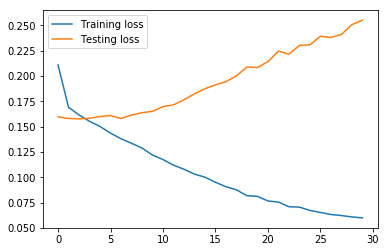

In [47]:
train_loss_2 = history.history['loss']
test_loss_2 = history.history['val_loss']
plt.plot(train_loss_2, label='Training loss')
plt.plot(test_loss_2, label='Testing loss')
plt.legend()

In [48]:
len(model_4.predict(test_data)), sum(model_4.predict(test_data))

(116293, array([0.], dtype=float32))

### Evaluate

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate (X_test, y_test, model):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return("tn: {}, fp: {}, fn: {}, tp: {}".format (tn, fp, fn, tp))

In [ ]:
models = [logreg, gs_dt, gs_rf, gs_ada, clf_c_pipe]
for model in models:
    print (evaluate (X_test, y_test, model))